# Van-der-Waals Corrections  
**by <span style="color:darkgreen">Sven Lubeck</span> & <span style="color:darkgreen">Pasquale Pavone</span> for [<span style="color:darkgoldenrod">exciting *neon*</span>](https://www.exciting-code.org/neon)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Mara Voiculescu</span> & <span style="color:darkgreen">Martin Kuban</span>)</font>
<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial, you will learn how to perform **`exciting`** calculations for materials that are significantly affected by van der Waals (**vdW**) forces. Since most of the common exchange-correlation functionals fail to describe these long-range dispersion interactions adequately, it is necessary to introduce further corrections. Two rather empirical, but therefore efficient, correction methods are available in **`exciting`**. There is, on the one hand, **DFT-D2** by Stefan Grimme [**1**], and on the other hand, **TS-vdW** by Alexandre Tkatchenko and Matthias Scheffler [**2**]. We will use these two methods to investigate the binding between the layers in graphite.
<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">

**Table of Contents**
    
[0. Before Starting](#0)
    
[1. Introduction](#1)  
    
[2. Graphite: Set up the Calculations](#2)
   - Preparation of the Input File
   - Generation of Input Files for Different Interlayer Spacings 

[3. Graphite: Perform the Calculation](#3)
    
[4. Graphite: Binding Energy Curve](#4)

[5. Graphite: Compare Correction Methods](#5)      

[Literature](#6)
</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Before Starting</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **`exciting`**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>

As a first step, you may create a running directory for the notebook.

In [1]:
%%bash
mkdir -p run_tutorial_van_der_waals_corrections

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Introduction</span>


In order to take **vdW** interaction into account, we may add an empirical energy correction to the standard **DFT** total energy

$$E_{\text{DFT}+\text{disp}}=E_{\text{DFT}} + E_{\text{disp}} .$$

This energy correction arises from a sum over pairwise $C_6/R^6$-potentials

$$E_{\text{disp}}=-\frac{1}{2}s_6 \sum_{A \neq B}\frac{C_6^{AB}}{\left(R^{\!AB}\right)^6}\,f_{\text{dmp}}\!\left( R^{AB}, R^A_0, R^B_0\right) .$$

Here, $s_6$ is a global scaling factor for all dispersion coefficients $C_6^{AB}$. The sum goes over all atoms $A$ and $B$ that are in the system. In practice, this sum is of course truncated (see cutoff parameter in the input reference). $R^{AB}$ denotes the distance between atom $A$ and $B$. $f_{\text{dmp}}\!\left( R^{AB}, R^A_0, R^B_0\right)$ is a damping function that ensures that the correction is only applied in the long-range domain. This function should turn to zero in case the atomic separation $R^{AB}$ is much smaller than the sum of the atomic van der Waals radii $R^A_0$ and $R^B_0$. In this region, the $C_6/R^6$-potential in is not a valid description and should therefore be suppressed. In the case that $R^{AB}$ is much larger than the sum of the individual van der Waals radii, the damping function should turn to one, since the correction should be fully accounted for in this region. A possible choice for a damping function is

$$f_{\text{dmp}}\!\left( R^{AB}, R^A_0, R_B^0\right) = \left\lbrace 1+\exp\left[-d\left( \frac{R^{AB}}{s_{_{\!R6}}\left(R^A_0 + R^B_0 \right)} - 1 \right)\right]\right\rbrace^{-1}$$

which is similar to a Fermi-Dirac distribution. It includes two parameters $d$ and $s_{_{\!R6}}$. The first parameter d determines the steepness of the damping function. The second parameter $s_{_{\!R6}}$ is a global scaling factor for all atomic van der Waals radii $R^A_0$.

The main difference between the two methods **DFT-D2** and **TS-vdW** is that the $C_6$ and $R^A_0$ coefficients in the **TS-vdW** scheme depend on the electron density, whereas in **DFT-D2** they are static parameters which do not depend on the chemical environment of the considered atom.

<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. Graphite: Set up the Calculations</span>

#### <span style="color:#15317E">i) Preparation of the Input File</span>

First of all, create an **`exciting`** input file called **input.xml** for the system under investigation in your running directory. As an example, you can find an input file for graphite below.

<span class="GRAPHITE"></span>
```xml
<input>
 
   <title>Graphite</title>
 
   <structure speciespath="$EXCITINGROOT/species">
      <crystal scale="1.88973" stretch="2.46 2.46 6.60">
         <basevect>0.5 0.8660254038 0.0</basevect>
         <basevect>1.0 0.0000000000 0.0</basevect>
         <basevect>0.0 0.0000000000 1.0</basevect>
      </crystal>
      <species speciesfile="C.xml" rmt="1.2">
         <atom coord="0.00000000 0.00000000 0.0"></atom>
         <atom coord="0.00000000 0.00000000 0.5"></atom>
         <atom coord="0.66666667 0.66666667 0.0"></atom>
         <atom coord="0.33333333 0.33333333 0.5"></atom>
      </species>
   </structure>
 
   <groundstate
       rgkmax="6.0"
       gmaxvr="20"
       ngridk="10 10 4"
       xctype="GGA_PBE"
       vdWcorrection="DFTD2">
   </groundstate>
 
</input>

```

In [5]:
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("07_tutorial_van_der_waals_corrections", "GRAPHITE")

# Write out the input as an XML file:
with open('./run_tutorial_van_der_waals_corrections/input.xml', "w") as fid:
    fid.write(input_str)

Do not forget to insert the correct path for the species files. For that, simply use the following command.

In [6]:
%%bash
cd run_tutorial_van_der_waals_corrections
python3 -m excitingscripts.setup.excitingroot
cd ..

Please note that the values of the attributes <code><span style="color:mediumblue">rgkmax</span></code> and <code><span style="color:mediumblue">ngridk</span></code> do not correspond to accurate calculations. These values are chosen to reduce the computing time. In order to obtain meaningful results, these parameters must be converged with respect to the quantity of interest.

In the input file above, we use **DFT-D2** as a **vdW** correction. This is controlled by the attribute <code><span style="color:mediumblue">vdWcorrection</span></code>. There are three possible values for this attribute, namely <code><span style="color:firebrick">"DFTD2"</span></code>, <code><span style="color:firebrick">"TSvdW"</span></code>, and <code><span style="color:firebrick">"none"</span></code>, where the last one is the default value.

#### <span style="color:#15317E">ii) Generation of Input Files for Different Interlayer Spacings</span>

In order to generate input files for a series of interlayer distances, you can run the script **`excitingscripts.setup.interlayer_distance`** as:

```bash
python3 -m excitingscripts.setup.interlayer_distance -r rundir dmin dmax nr_displ dinfty
```
Here, <code>rundir</code> is the running directory, <code>dmin</code> and <code>dmax</code> are the minimum and maximum values for the interlayer distance, 
<code>nr_displ</code> is the number of distances in the interval [<code>dmin</code>, <code>dmin</code>] and
<code>dinfty</code> is the interlayer distance at infinity.

In this way, you can start by creating a working directory for the calculation and execute the script as shown below.

In [7]:
%%bash
cd run_tutorial_van_der_waals_corrections
mkdir -p DFTD2 
python3 -m excitingscripts.setup.interlayer_distance -r DFTD2 5 8 10 20
cd ..

In this example, the working directory is named **DFTD2**. Here, we generate input files for 11 different structures. 10 of these have interlayer separations between 5 Bohr and 8 Bohr. **The last structure (the 11th one) has an interlayer separation of 20 Bohr**. This last calculation provides a reference energy for all other calculations. Indeed, the interlayer separation for the reference energy would be the same as for an isolated monolayer and therefore infinite. However, the corresponding calculation would not be feasible due to the enormous computational costs. Therefore, convergence tests are needed in order to select the appropriate interlayer separation of the reference structure. The minimum total energies of all structures with respect to the (converged) reference energy can be interpreted as binding energies. In order to obtain meaningful binding energies, then, you should **converge the reference energies with respect to the interlayer distance**.

<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. Graphite: Perform the Calculation</span>

To execute the series of calculation with input files created by **`excitingscripts.setup.interlayer_distance`** you have to run the script **`excitingscripts.execute.elastic_strain`**. If a name for the working directory has been specified, then you **must** give it here too, as well as the values for <code>nr_displ</code> and <code>dinfty</code>.

In [12]:
%%bash
cd run_tutorial_van_der_waals_corrections
python3 -m excitingscripts.execute.elastic_strain -r DFTD2
cd ..

After the complete run, the results of the calculations are contained in the subdirectory **rundir-i** where **i** runs from **1** to the total number of structures. For the reference calculation at "infinite" interlayer separation **i** takes the value **oo**. The data for binding energy curves are contained in the file **energy-vs-strain**.

<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. Graphite: Binding Energy Curve</span>

Inside the directory where the file **energy-vs-strain** is located, you can run the script **`excitingscripts.plot.energy`**. This will produce a file named **PLOT.png** which should contain the following figure.

In [13]:
%%bash
cd run_tutorial_van_der_waals_corrections/DFTD2
python3 -m excitingscripts.plot.energy
cd ../..

<figure>
<img src=" 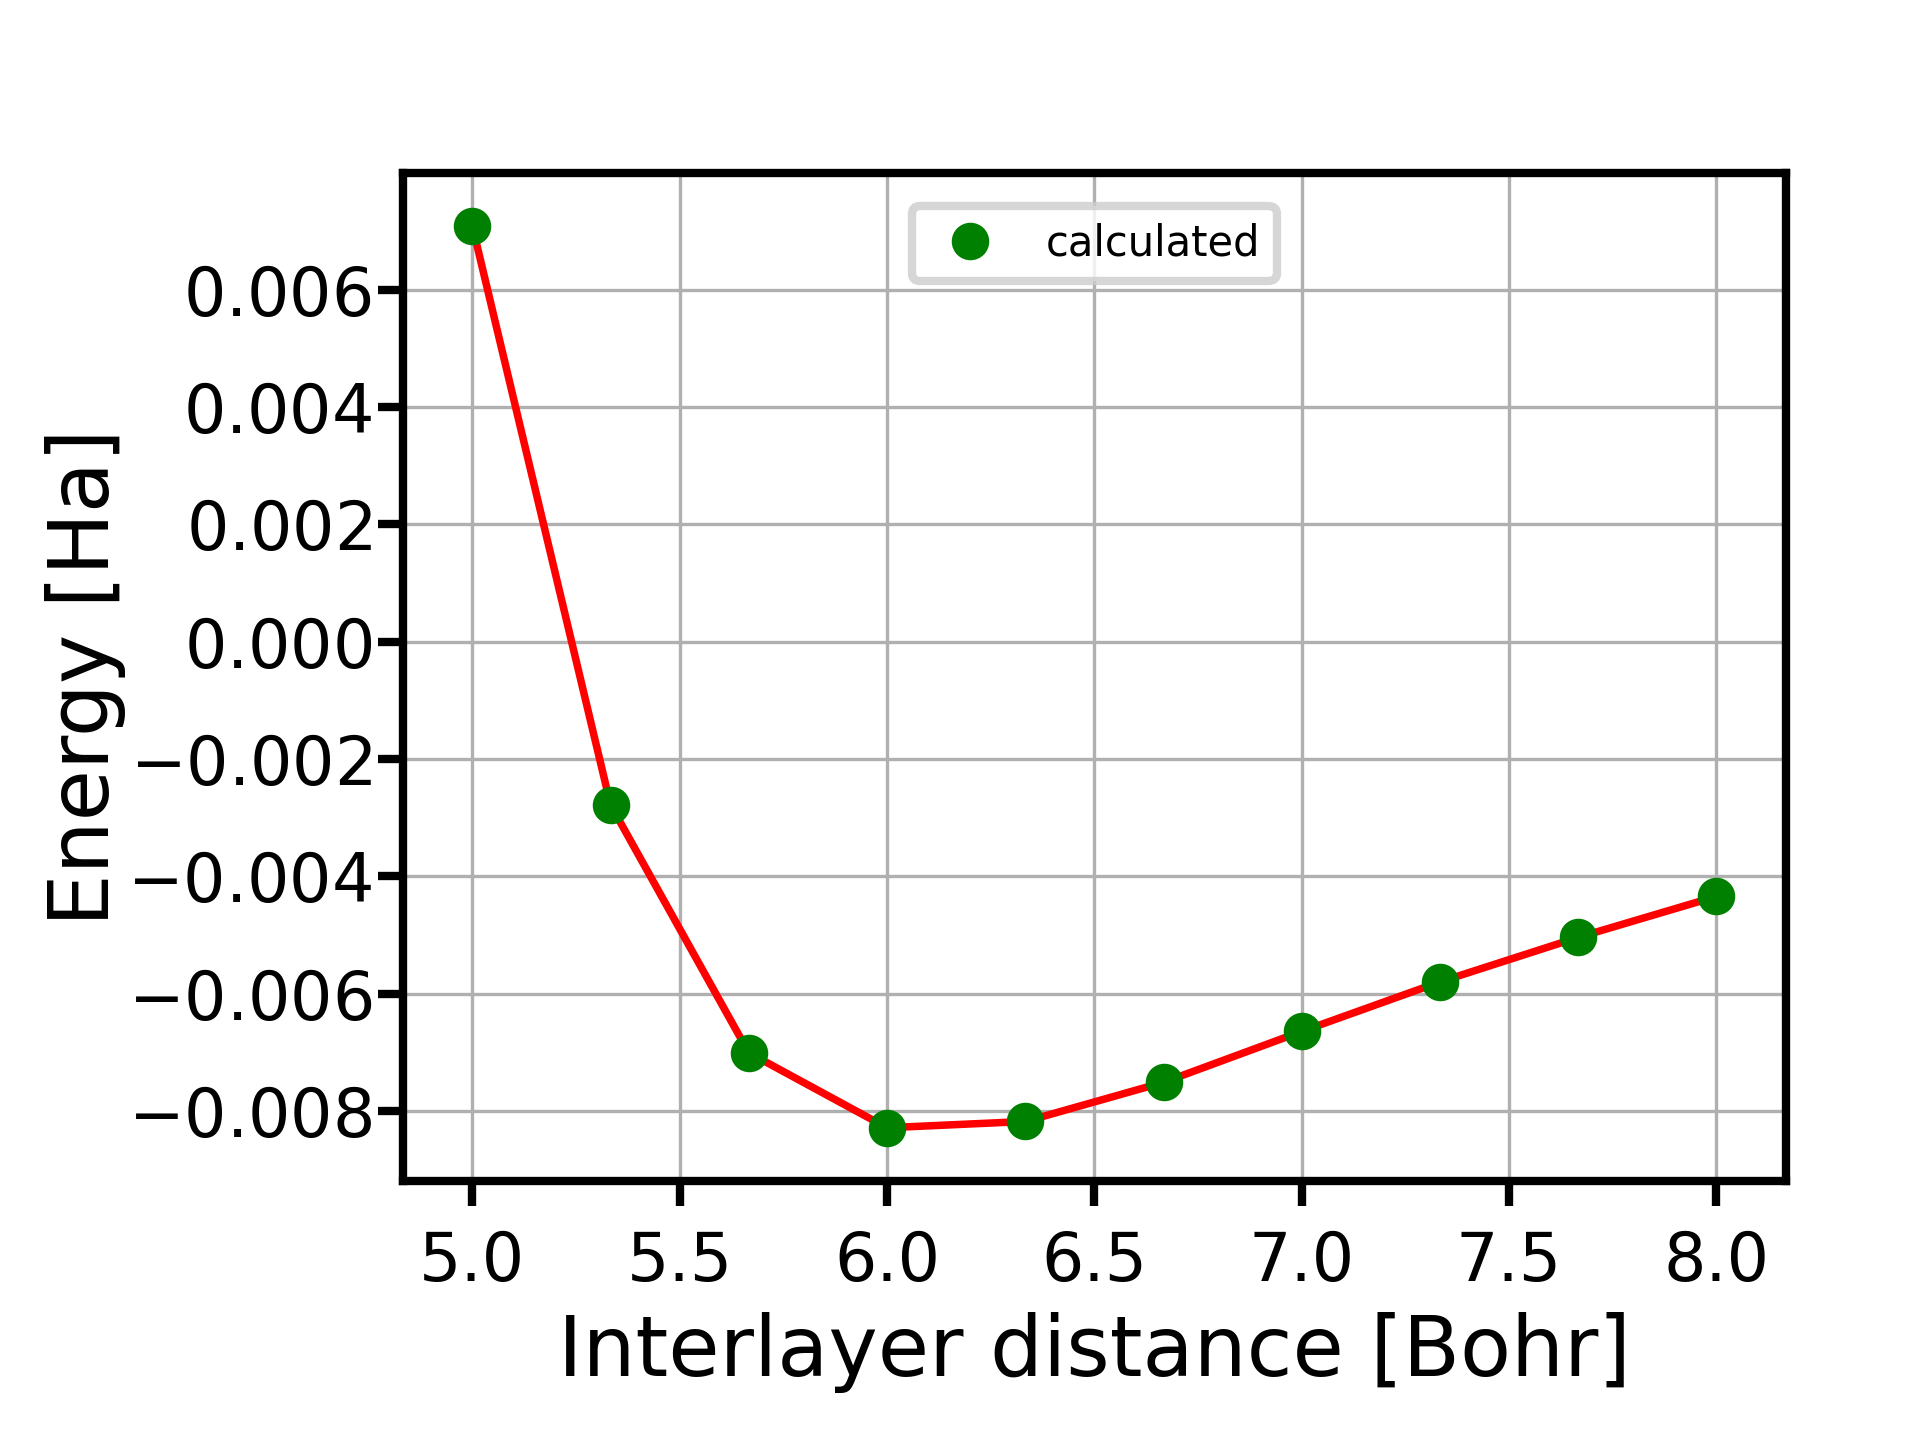" width="600" align="left"/>
</figure>

If the reference calculation in directory **rundir-oo** is already performed, the script will also produce the file **normalized-energy** which contains the effective binding energies with respect to the reference energy from **rundir-oo**.

<a id='5'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. Graphite: Compare Correction Methods</span>
In order to obtain a binding energy curve for the **TS-vdW** correction, simply replace the following line in the input file **input.xml**
```xml
 vdWcorrection="DFTD2">
```
by
```xml
 vdWcorrection="TSvdW">
```
and repeat the procedure from above.

In [14]:
# The following lines modify the input.xml using Python

from excitingtools import ExcitingInputXML

parsed_input = ExcitingInputXML.from_xml('./run_tutorial_van_der_waals_corrections/input.xml')
parsed_input.groundstate.vdWcorrection = "TSvdW"
parsed_input.write('./run_tutorial_van_der_waals_corrections/input.xml')

In [15]:
%%bash
cd run_tutorial_van_der_waals_corrections
mkdir -p TSvdW 
python3 -m excitingscripts.setup.interlayer_distance -r TSvdW 5 8 10 20
python3 -m excitingscripts.execute.elastic_strain -r TSvdW 
cd TSvdW
python3 -m excitingscripts.plot.energy
cd ../..

You will obtain the following figure.

<figure>
<img src=" 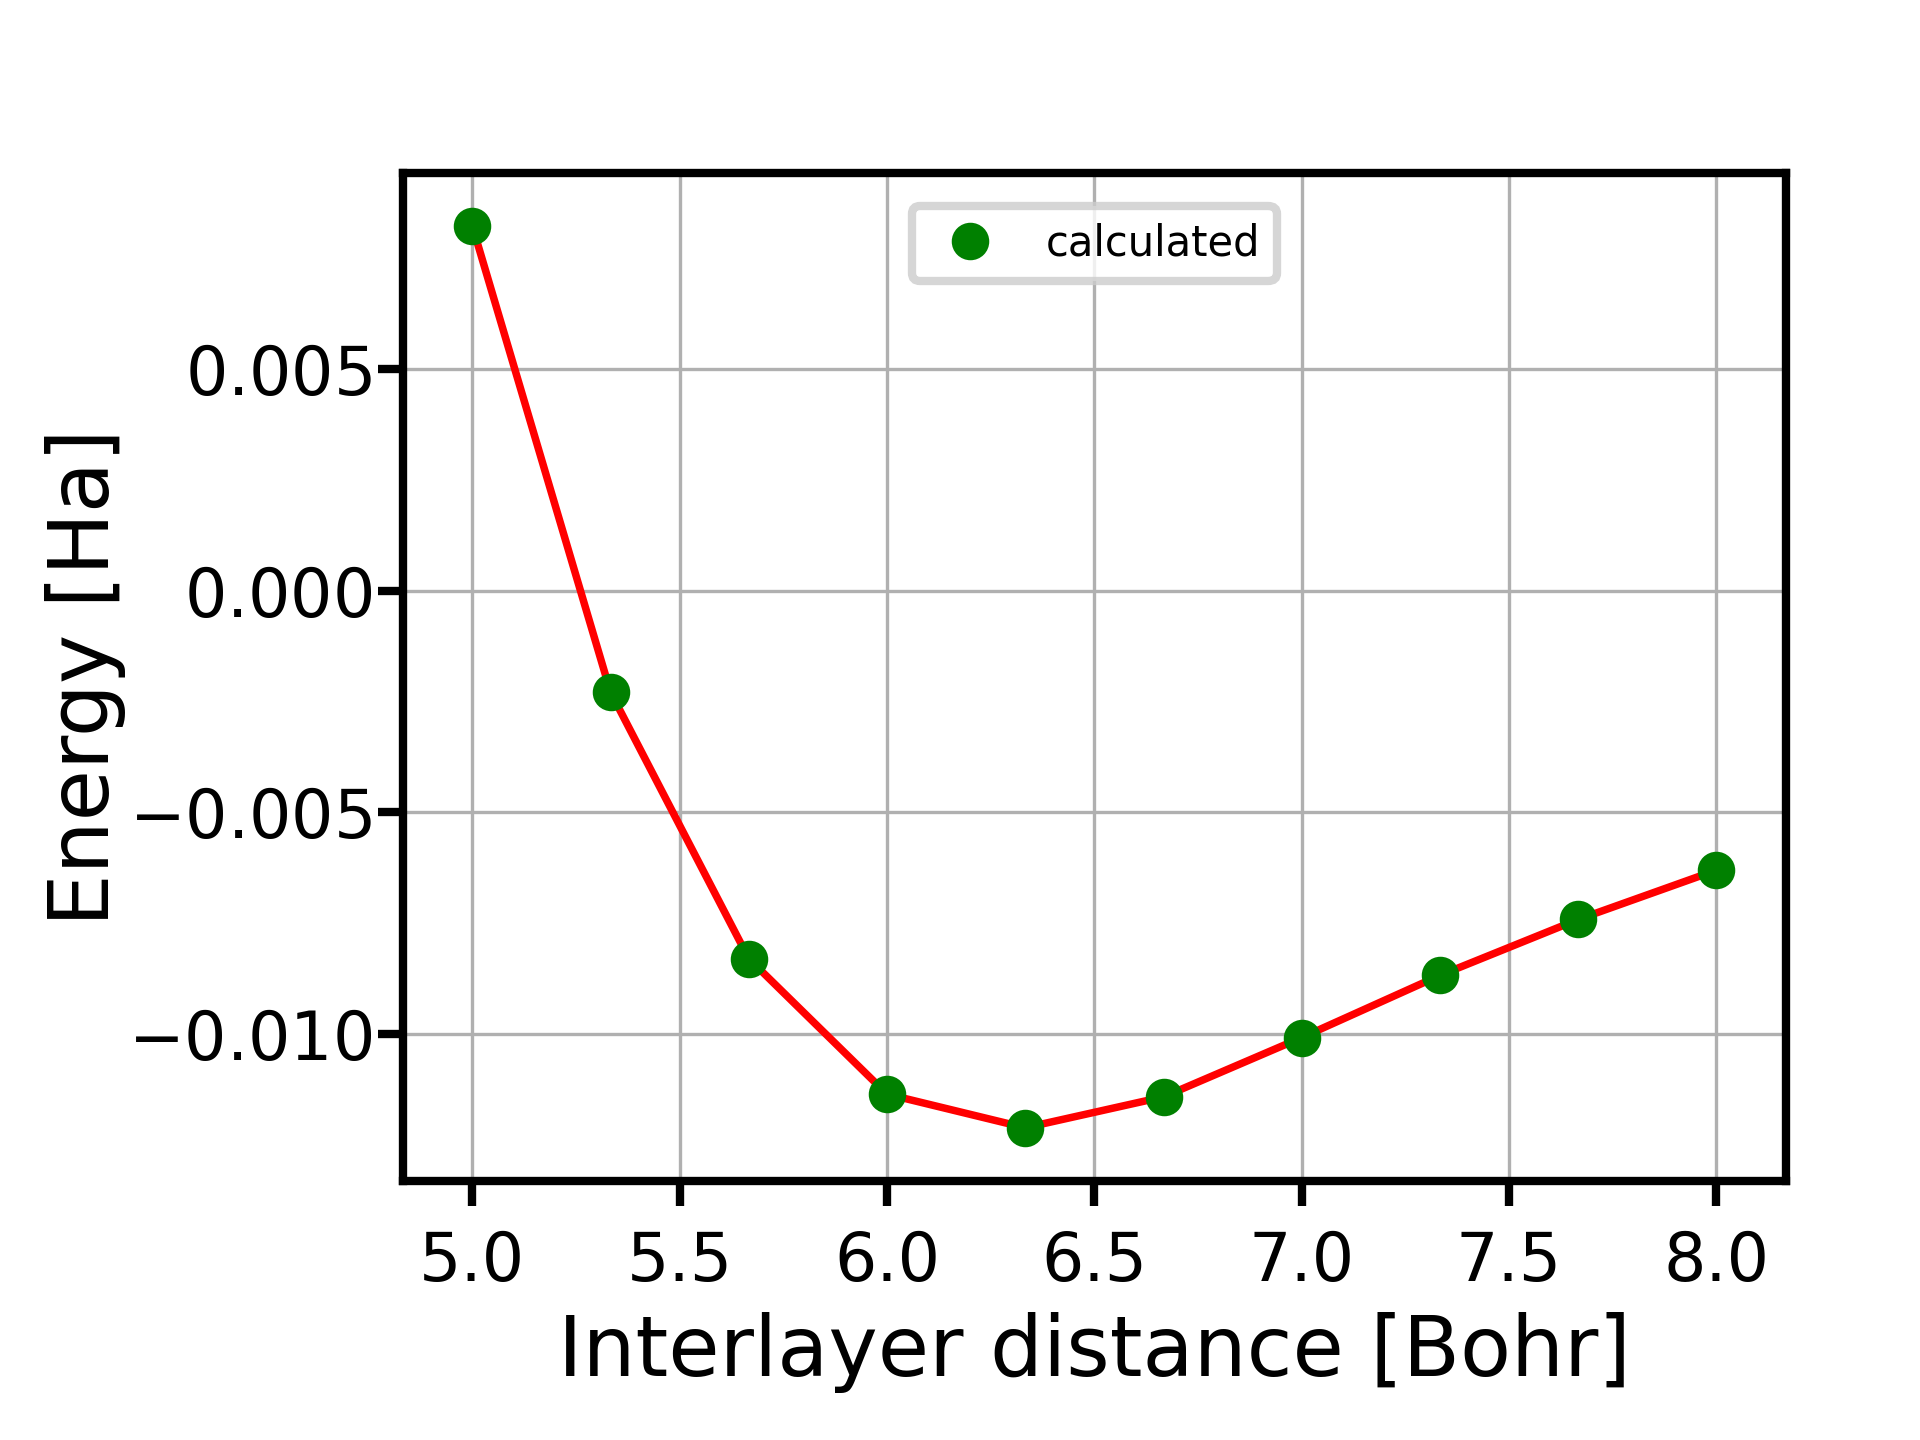" width="600" align="left"/>
</figure>

You can also repeat this procedure for the uncorrected **PBE** case, *i.e.*, replace the following line in the input file 
```xml
 vdWcorrection="TSvdW">
```
by
```xml
 vdWcorrection="none">
```
or just delete this attribute.

In [16]:
# The following lines modify the input.xml using Python

parsed_input = ExcitingInputXML.from_xml('./run_tutorial_van_der_waals_corrections/input.xml')
parsed_input.groundstate.vdWcorrection = "none"
parsed_input.write('./run_tutorial_van_der_waals_corrections/input.xml')

In [21]:
%%bash
cd run_tutorial_van_der_waals_corrections
mkdir -p PBE-uncorrected 
python3 -m excitingscripts.setup.interlayer_distance -r PBE-uncorrected 5 8 10 20
python3 -m excitingscripts.execute.elastic_strain -r PBE-uncorrected 
cd PBE-uncorrected
python3 -m excitingscripts.plot.energy
cd ../..

If you perform this series of calculations in a directory named **PBE-uncorrected**, you can create a figure with all three binding energy curves by running the script **`excitingscripts.plot.compare_vdW`** as follows.

In [22]:
%%bash
cd run_tutorial_van_der_waals_corrections
python3 -m excitingscripts.plot.compare_vdW -f normalized-energy -r DFTD2 TSvdW PBE-uncorrected
cd ..

<figure>
<img src=" 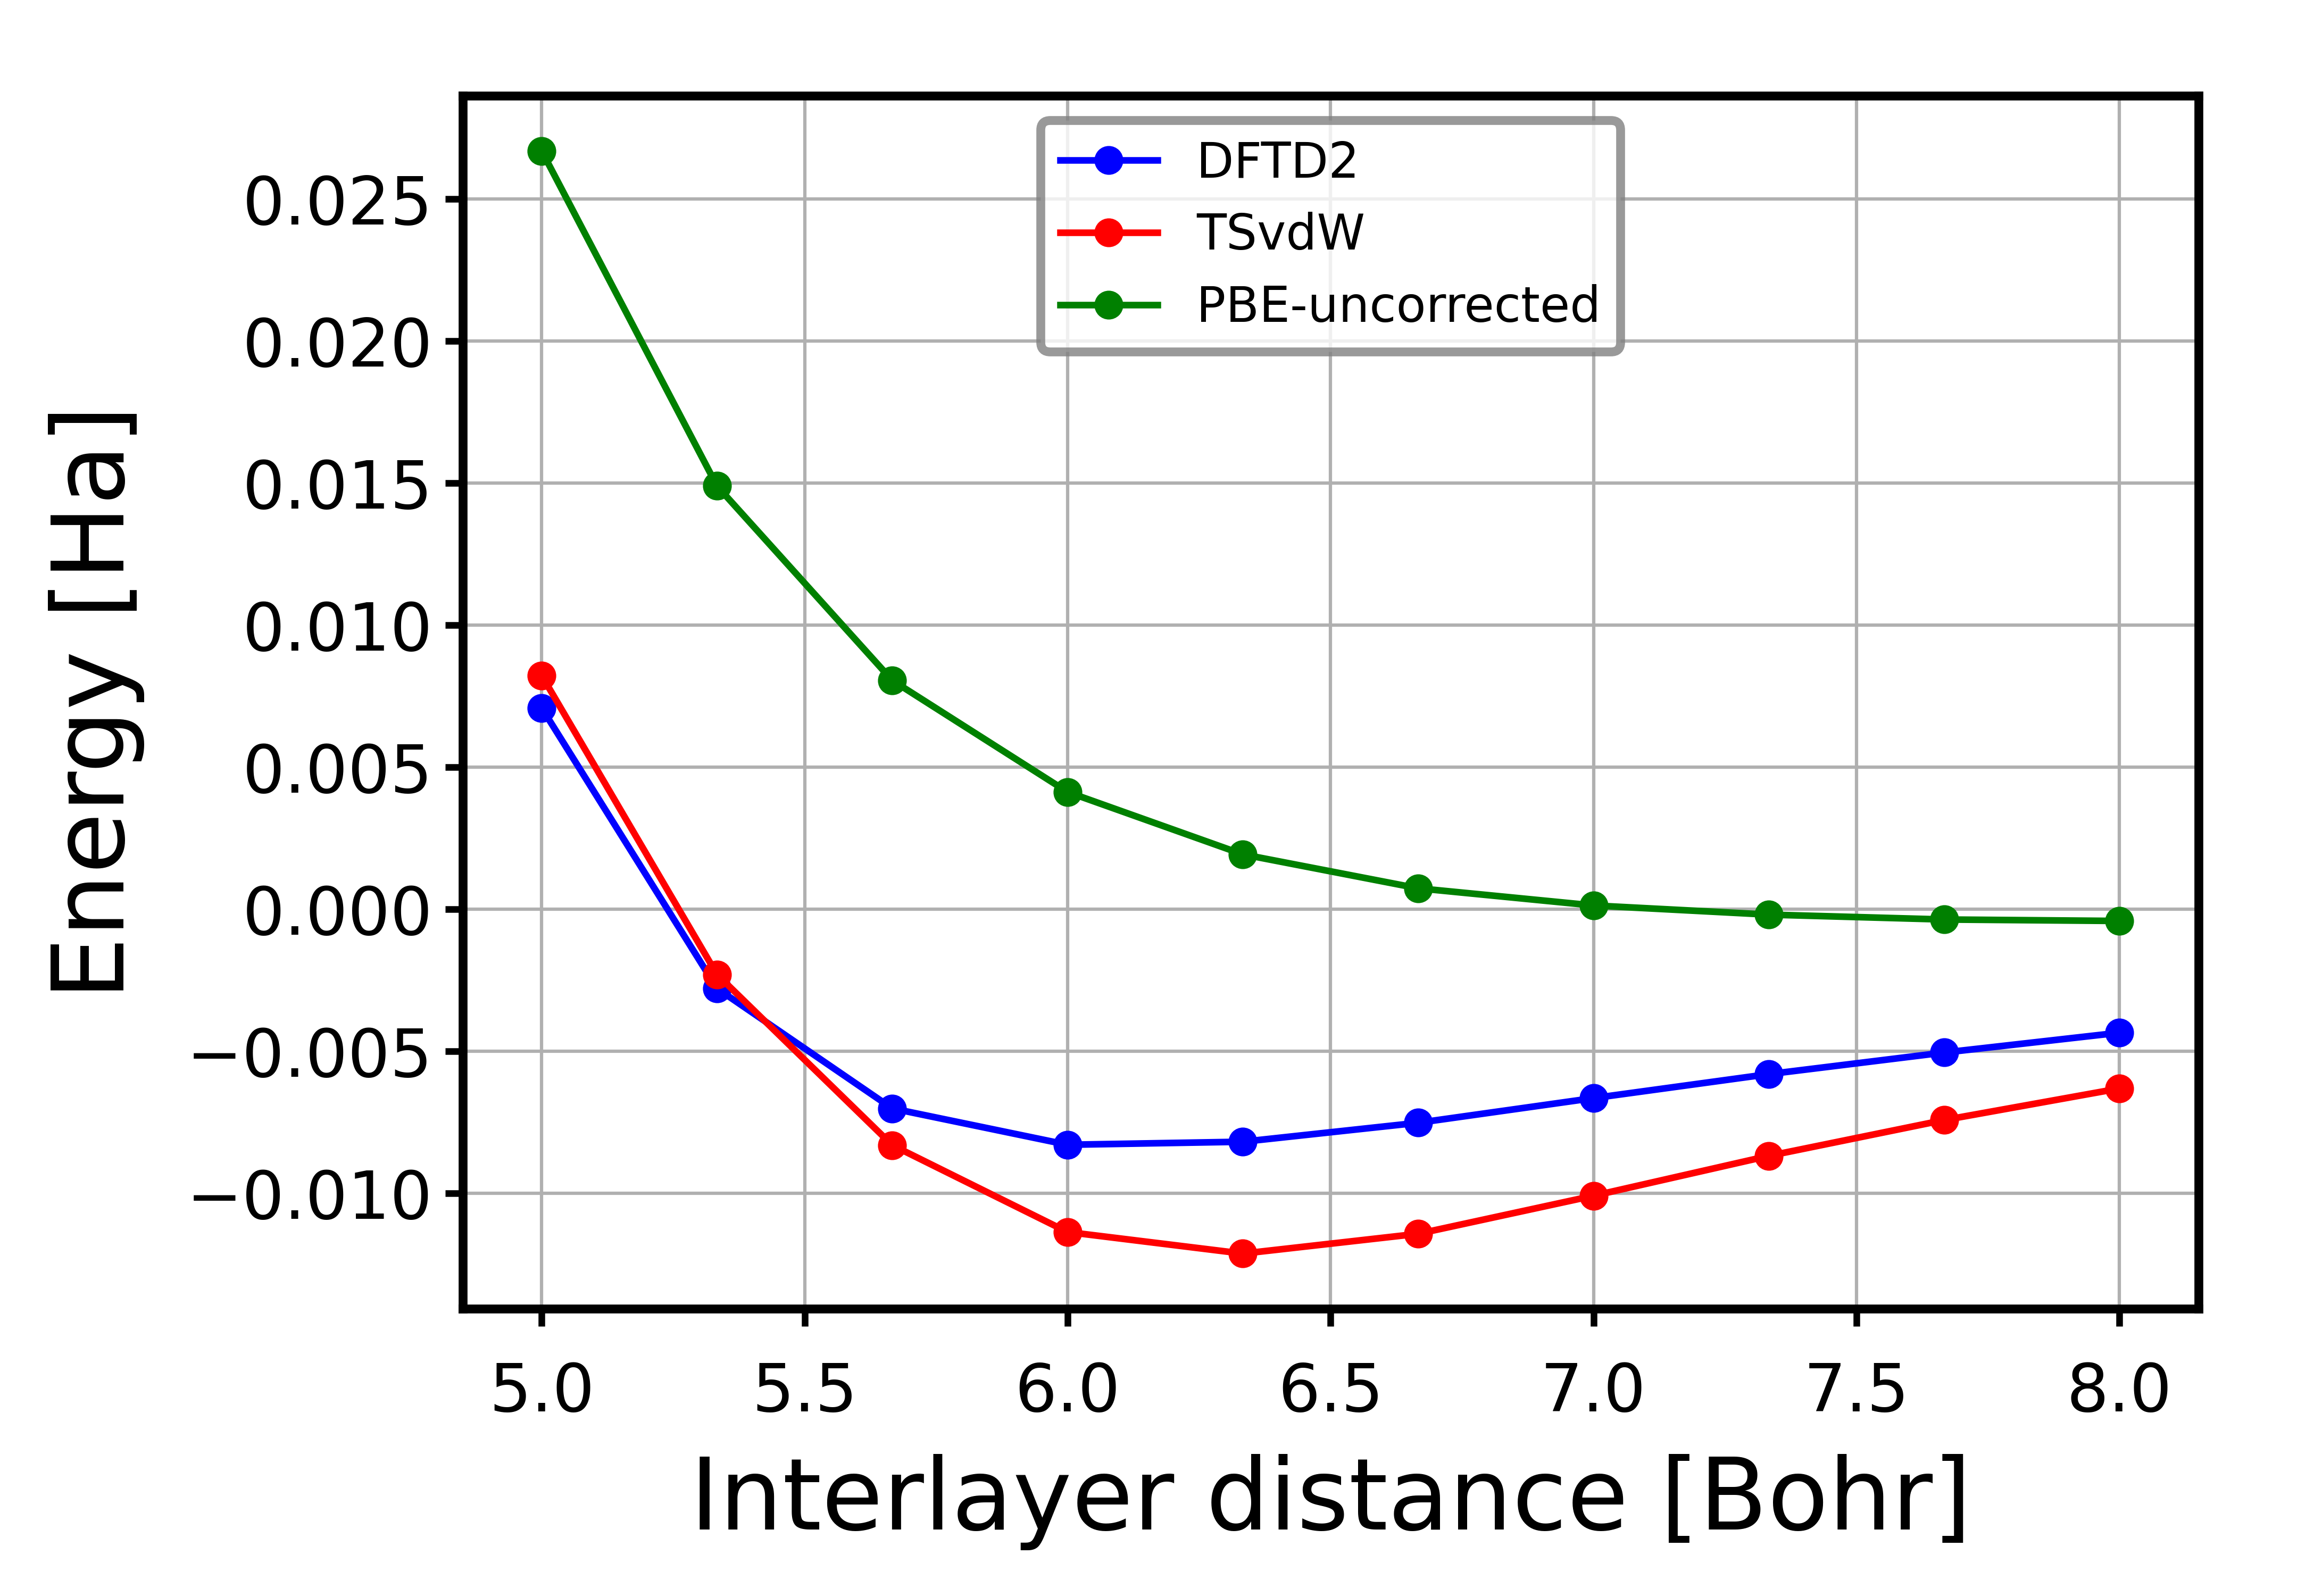" width="600" align="left"/>
</figure>

<a id='6'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">Literature</span>

**1.** Grimme, Stefan. "*Semiempirical GGA-type density functional constructed with a long-range dispersion correction.*" Journal of Computational Chemistry 27.15 (2006): 1787-1799.

**2.** Alexandre Tkatchenko and Matthias Scheffler. "*Accurate molecular van-der-Waals interactions from ground-state electron density and free-atom reference data.*" Phys. Rev. Lett. **102**, 073005 (2009).
<hr style="border:2px solid #DDD"> </hr>